**This project consists of 4 sections:**

1) Set up and importing data

2) Coding and running technical indicators

3) Defining and coding buy and sell signal

4) Results

*Strategy provides an excess 18.78% return over buying and holding (Rs1,57,137 with strategy vs Rs1,38,355 without strategy from an initial investment of Rs1,00,000) and generates a 19.81% CAGR over 30 months*

# 1. Set up and importing data

In [202]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as pta
from datetime import date
from nsepy import get_history


Getting data from nsepy

In [203]:
sbin = get_history(symbol='SBIN',
                   start=date(2018,1,10),
                   end=date(2021,6,29))

Cleaning up the dataframe received from NSEPY
(Remove unwanted columns - Series, Prev Close, Trades, Turnover, VWAP, Last, %Deliverble)


In [204]:
del sbin['Series']
del sbin['Prev Close']
del sbin['Trades']
del sbin['%Deliverble']
del sbin['Turnover']
del sbin['VWAP']
del sbin['Last']
del sbin['Deliverable Volume']

### Visualizing data

In [205]:
sbin

,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2018-01-10,SBIN,304.65,305.85,300.00,301.10,13064599
2018-01-11,SBIN,300.90,303.00,300.00,302.20,12299087
2018-01-12,SBIN,304.65,304.65,300.55,302.25,17594228
2018-01-15,SBIN,303.95,305.25,301.55,302.60,18189668
2018-01-16,SBIN,302.40,303.35,295.30,296.15,18040940
...,...,...,...,...,...,...
2021-06-23,SBIN,421.10,424.75,415.00,418.85,27564829
2021-06-24,SBIN,420.35,422.75,416.30,417.20,19214547
2021-06-25,SBIN,421.00,431.00,419.05,428.80,29886797


Here, the column indexes are  
Open = 1  
High = 2  
Low = 3  
Close = 4  
Volume = 5  
Candlesticks = 6  
Patterns = 7  
shorterEMA = 8  
longerEMA = 9  
MACD = 10  
Signal Line = 11  
RSI = 12    
 
Buy Signal = 14  
Sell Signal = 15  

These will be required for coding the candlestick patterns and indicators, so that we can use the .iat[] .iloc[] indexers in python to locate and change cell values. Using the integer column indexes provide These indexers only accept integer index values and do not accept label names.

In [206]:
def chart(df):
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Date')
    plt.ylabel('Price')
    df['Close'].plot(label='Closing prices', color='red')
    df['RSI'].plot(label='RSI', color = 'blue')
    df['MACD'].plot(label='MACD', color = 'green')

In [207]:
def candlechart(df):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

Candlestick chart demonstration

In [208]:
candlechart(sbin)

# 2. Coding and running technical indicators

For the indicators, I will be using 

1) Candlesticks\
    a) Shooting star\
    b) Bullish Marubozu\
    c) Bearish Marubozu

2) Technical Indicators\
    a) MACD\
    b) RSI\
    c) Volume (It is already present in the data from nsepy)

In [209]:
#Candlesticks

def label_cndl(df):
    df['Candlesticks'] = ""
    df['Patterns'] = "-"
    for i in range(len(df.index)):
        if df.iat[i, 4] < df.iat[i, 1]:
            df.iat[i, 6] = 'Red'
        elif df.iat[i, 4] > df.iat[i, 1]:
            df.iat[i, 6] = 'Green'

In [210]:
label_cndl(sbin)

In [211]:
sbin

,Symbol,Open,High,Low,Close,Volume,Candlesticks,Patterns
Date,,,,,,,,
2018-01-10,SBIN,304.65,305.85,300.00,301.10,13064599,Red,-
2018-01-11,SBIN,300.90,303.00,300.00,302.20,12299087,Green,-
2018-01-12,SBIN,304.65,304.65,300.55,302.25,17594228,Red,-
2018-01-15,SBIN,303.95,305.25,301.55,302.60,18189668,Red,-
2018-01-16,SBIN,302.40,303.35,295.30,296.15,18040940,Red,-
...,...,...,...,...,...,...,...,...
2021-06-23,SBIN,421.10,424.75,415.00,418.85,27564829,Red,-
2021-06-24,SBIN,420.35,422.75,416.30,417.20,19214547,Red,-
2021-06-25,SBIN,421.00,431.00,419.05,428.80,29886797,Green,-


Now, we have to mark the locations at which candlestick patterns have been found.

### Candlestick patterns coding

In [212]:
def shootingstar(df):
    '''Checking if the last two days were green candles, and the next two days are red candles. Also we look for a negligible body to wick ratio'''
    for i in range(len(df.index)-2):
        if((df.iat[i-2,6] == 'Green' and df.iat[i-1,6] == 'Green') and (df.iat[i+2,6] == 'Red' and df.iat[i+1,6] == 'Red')):
            if(df.iat[i,2] - df.iat[i,3] > 4*abs(df.iat[i,1]-df.iat[i,4])):
                df.iat[i,7]='Shooting Star'

def marubozu(df):
    ''' We are just checking if the body of the candle is 5 times larger than one of the wicks'''
    for i in range(len(df.index)):
        if df.iat[i, 6] == 'Green':
            if abs(df.iat[i, 1]-df.iat[i, 4]) > 4 * abs(df.iat[i,2] - df.iat[i,4]):
                df.iat[i, 7] = 'Bullish Marubozu'
        elif df.iat[i, 6] == 'Red':
            if abs(df.iat[i, 1]-df.iat[i, 4]) > 4 * abs(df.iat[i,1] - df.iat[i,3]):
                df.iat[i, 7] = 'Bearish Marubozu'
        

In [213]:
def label_ptrns(df):
    shootingstar(df)
    marubozu(df)
    
label_ptrns(sbin)

### Technical indicators coding

In [214]:
def MACD(df,shorter,longer):
    df['shorterEMA'] = df['Close'].ewm(span=shorter).mean()
    df['longerEMA'] = df['Close'].ewm(span=longer).mean()
    df['MACD'] = df['shorterEMA'] - df['longerEMA']
    df['Signal Line'] = df['MACD'].ewm(span=9).mean()
    
def RSI(df,days):
    df['RSI']=pta.rsi(df['Close'],length=days)
    
def indicators(df):
    MACD(df, 12, 26)
    RSI(df, 14)
    
#To customize the period, use the MACD and RSI methods instead of indicators method

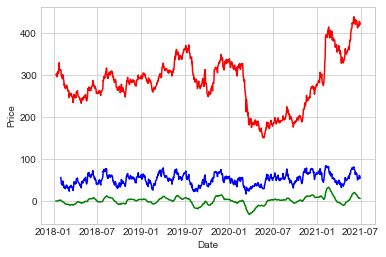

In [215]:
indicators(sbin)
chart(sbin)

# 3. Setting up buy and sell signals

#### Buy signals:
We will go long if
1) Bullish MACD crossover occurs  
2) RSI is in our favour  

We will increase our investment if volume increases drastically while the market is still moving in our favour 

#### Sell signals:
We will short if 
1) Bearish MACD crossover occurs  
2) RSI is in our favour  

We will short more if volume increases drastically while the market is still moving in our favour

#### Costs:
Transaction costs: 0.03%

Lot size will be 10 for this project, can be changed in the buy() and sell() functions

In [225]:
def applyTransactionCosts(amt):
    return amt * 0.0003


def buySignal(df,i):
    df.iloc[i,14] = True
    return df
    
def sellSignal(df,i):
    df.iloc[i,15] = True
    return df

##########################################################################
#All the functions related to current trades

def buy(df,i):
    lot_size = 5
    if df.iloc[i,14] == True and df.iloc[i,13] > df.iloc[i,1] * lot_size:
        df.iloc[i,13] = df.iloc[i,13] - df.iloc[i,1] * lot_size - applyTransactionCosts(df.iloc[i,1] * lot_size)
        df.iloc[i,16] = df.iloc[i,16] + df.iloc[i,1] * lot_size
        df.iloc[i,17] = df.iloc[i,17] + lot_size
        print("buy")
    return df
            

def sell(df,i):
    lot_size = 5
    if df.iloc[i,15] == True and df.iloc[i,17] > lot_size and df.iloc[i,16] > df.iloc[i,1] * lot_size:
        df.iloc[i,13] = df.iloc[i,13] + df.iloc[i,1] * lot_size - applyTransactionCosts(df.iloc[i,1] * lot_size)
        df.iloc[i,16] = df.iloc[i,16] - df.iloc[i,1] * lot_size 
        df.iloc[i,17] = df.iloc[i,17] - lot_size
        print("sell")
    return df
            


def isCurrentRSIok(df, i):
    if df.iat[i, 12] >= 70:
        return 'Overbought'
    if df.iat[i, 12] <= 30:
        return 'Oversold'
    else:
        return "OK"
    



def patternCheck(df, i):
    if df.iloc[i,7] != "-":
        if df.iloc[i,7] == "Shooting star":
            sellSignal(df,i+2)
        elif df.iloc[i,7] == "Bullish Marubozu":
            buySignal(df,i)
        elif df.iloc[i,7] == "Bearish Marubozu":
            sellSignal(df,i)
    return df
    

def volumeCheck(df, i):
    if 1- df.iloc[i-1,5]/ df.iloc[i-1,5] > 0.15:
        if df.iloc[i,6] == "Green":
            buySignal(df,i)
        elif df.iloc[i,6] == "Red":
            sellSignal(df,i)
    return df
    
    


def currentTrades(df, i):
    if isCurrentRSIok(df,i) == "OK":
        volumeCheck(df,i)
        patternCheck(df,i)
    elif isCurrentRSIok(df,i) == "Overbought":
        sellSignal(df,i)
    elif isCurrentRSIok(df,i) == "Oversold":
        buySignal(df,i)
    return df

##########################################################################
#All the functions related to new trades


def MACDcheck(df,i):
#     if MACD just goes above signal line, bullish, buy
#     if MACD just goes below signal line, bearish, sell
    if df.iat[i, 10] - df.iat[i, 11] > 0 and df.iat[i-1, 10] - df.iat[i-1, 11] < 0:
        return 'Buy'
    if df.iat[i, 10] - df.iat[i, 11] < 0 and df.iat[i-1, 10] - df.iat[i-1, 11] > 0:
        return 'Sell'
        
def RSIcheck(df,i):
#     if RSI is 70+ and you want to sell, go ahead and sell
#     if RSI is 30- and you want to buy, go ahead and buy
    if df.iat[i, 12] >= 70:
        return 'Sell'
    if df.iat[i, 12] <= 30:
        return 'Buy'
    
    
def newTrades(df, i):
    if(MACDcheck(df,i) == "Buy" and RSIcheck(df,i) == "Buy"):
        buySignal(df,i)
    if(MACDcheck(df,i) == "Sell" and RSIcheck(df,i) == "Sell"):
        sellSignal(df,i)
    return df
    

##########################################################################

def signals(df):
    df['Balance'] = 100000
    df['Buy Signal'] = False
    df['Sell Signal'] = False
    df['Account'] = 0
    df['Quantity'] = 0
    df['Result'] = 0
    for i in range(len(df.index)):
        newTrades(df,i)
        currentTrades(df,i)
    return df
    
def trade(df):
    for i in range(len(df.index)):
        df.iloc[i,13] = df.iloc[i-1,13]
        df.iloc[i,16] = df.iloc[i-1,16]
        df.iloc[i,17] = df.iloc[i-1,17] 
        df.iloc[i,18] = df.iloc[i,13]+ 0.9997*df.iloc[i,4]*df.iloc[i,17]
        if df.iloc[i,14] == True:
            buy(df,i)
        if df.iloc[i,15] == True:
            sell(df,i)
        print(df.iloc[i,4], df.iloc[i,13], df.iloc[i,16])
    print("Result =",df.iloc[-1,13]+ 0.9997*df.iloc[-1,4]*df.iloc[-1,17])
    #0.9997 factor because of transaction costs 
        
signals(sbin)
trade(sbin)


301.1 100000 0
302.2 100000 0
302.25 100000 0
302.6 100000 0
296.15 100000 0
buy
307.1 98519.556 1480.0
303.25 98519.556 1480.0
buy
309.25 96999.350075 2999.75
306.5 96999.350075 2999.75
buy
318.1 95466.890475 4531.75
buy
329.9 93877.91392499999 6120.25
313.15 93877.91392499999 6120.25
312.1 93877.91392499999 6120.25
313.55 93877.91392499999 6120.25
313.25 93877.91392499999 6120.25
306.05 93877.91392499999 6120.25
297.35 93877.91392499999 6120.25
298.05 93877.91392499999 6120.25
291.75 93877.91392499999 6120.25
292.8 93877.91392499999 6120.25
buy
301.4 92412.97457499999 7584.75
296.4 92412.97457499999 7584.75
288.75 92412.97457499999 7584.75
276.2 92412.97457499999 7584.75
278.7 92412.97457499999 7584.75
271.65 92412.97457499999 7584.75
buy
268.5 91055.06732499998 8942.25
269.65 91055.06732499998 8942.25
273.3 91055.06732499998 8942.25
272.6 91055.06732499998 8942.25
276.05 91055.06732499998 8942.25
274.45 91055.06732499998 8942.25
267.6 91055.06732499998 8942.25
268.0 91055.0673249999

306.2 72236.76132499998 27737.75
buy
312.5 70701.80097499999 29272.25
309.95 70701.80097499999 29272.25
308.15 70701.80097499999 29272.25
310.0 70701.80097499999 29272.25
308.75 70701.80097499999 29272.25
305.45 70701.80097499999 29272.25
298.25 70701.80097499999 29272.25
299.3 70701.80097499999 29272.25
308.05 70701.80097499999 29272.25
306.9 70701.80097499999 29272.25
314.65 70701.80097499999 29272.25
312.1 70701.80097499999 29272.25
315.75 70701.80097499999 29272.25
319.25 70701.80097499999 29272.25
sell
344.7 72361.30297499998 27612.25
337.55 72361.30297499998 27612.25
341.1 72361.30297499998 27612.25
342.2 72361.30297499998 27612.25
sell
355.35 74085.53554999999 25887.5
sell
361.7 75860.25297499998 24112.25
sell
360.05 77664.46154999998 22307.5
348.65 77664.46154999998 22307.5
353.55 77664.46154999998 22307.5
352.5 77664.46154999998 22307.5
355.45 77664.46154999998 22307.5
352.4 77664.46154999998 22307.5
336.9 77664.46154999998 22307.5
buy
342.05 75978.95604999998 23992.5
344.3 75

192.7 733.55527499999 99210.25
186.05 733.55527499999 99210.25
183.8 733.55527499999 99210.25
186.25 733.55527499999 99210.25
188.2 733.55527499999 99210.25
190.75 733.55527499999 99210.25
194.4 733.55527499999 99210.25
192.0 733.55527499999 99210.25
198.25 733.55527499999 99210.25
191.95 733.55527499999 99210.25
187.15 733.55527499999 99210.25
189.45 733.55527499999 99210.25
191.2 733.55527499999 99210.25
186.55 733.55527499999 99210.25
191.45 733.55527499999 99210.25
192.25 733.55527499999 99210.25
191.6 733.55527499999 99210.25
191.45 733.55527499999 99210.25
190.95 733.55527499999 99210.25
190.65 733.55527499999 99210.25
193.8 733.55527499999 99210.25
195.05 733.55527499999 99210.25
203.3 733.55527499999 99210.25
201.9 733.55527499999 99210.25
196.5 733.55527499999 99210.25
193.1 733.55527499999 99210.25
195.1 733.55527499999 99210.25
197.05 733.55527499999 99210.25
194.75 733.55527499999 99210.25
198.4 733.55527499999 99210.25
201.45 733.55527499999 99210.25
207.95 733.55527499999

In [217]:
sbin

,Symbol,Open,High,Low,Close,Volume,Candlesticks,Patterns,shorterEMA,longerEMA,MACD,Signal Line,RSI,Balance,Buy Signal,Sell Signal,Account,Quantity,Result
Date,,,,,,,,,,,,,,,,,,,
2018-01-10,SBIN,304.65,305.85,300.00,301.10,13064599,Red,-,301.100000,301.100000,0.000000,0.000000,NaN,100000.0000,False,False,0.0,0,100000.000000
2018-01-11,SBIN,300.90,303.00,300.00,302.20,12299087,Green,-,301.695833,301.671154,0.024679,0.013711,NaN,100000.0000,False,False,0.0,0,100000.000000
2018-01-12,SBIN,304.65,304.65,300.55,302.25,17594228,Red,-,301.912125,301.879128,0.032997,0.021615,NaN,100000.0000,False,False,0.0,0,100000.000000
2018-01-15,SBIN,303.95,305.25,301.55,302.60,18189668,Red,-,302.129260,302.080652,0.048608,0.030759,NaN,100000.0000,False,False,0.0,0,100000.000000
2018-01-16,SBIN,302.40,303.35,295.30,296.15,18040940,Red,-,300.504716,300.705309,-0.200593,-0.038063,NaN,100000.0000,False,False,0.0,0,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23,SBIN,421.10,424.75,415.00,418.85,27564829,Red,-,421.591747,414.343649,7.248097,11.108623,54.477252,49686.9154,False,False,50224.5,255,156461.623375
2021-06-24,SBIN,420.35,422.75,416.30,417.20,19214547,Red,-,420.916093,414.555231,6.360862,10.159071,52.971133,49686.9154,False,False,50224.5,255,156040.999600
2021-06-25,SBIN,421.00,431.00,419.05,428.80,29886797,Green,-,422.129002,415.610399,6.518603,9.430977,61.111190,49686.9154,False,False,50224.5,255,158998.112200


# 4. Results 

#### Function to visualize profit or loss made over time 

In [218]:
%matplotlib inline 

def plotter(df):
    x = df.index
    y1 = df['Result']
    y2 = df['No Strat Return']

    plt.plot(x,y1,color='red')
    plt.plot(x,y2,color='black')

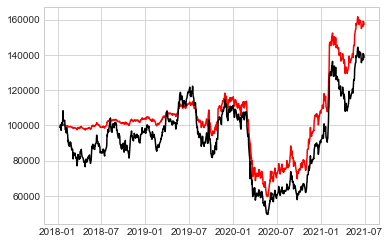

In [223]:
def noStratReturn(df):
    df['No Strat Return'] = 0
    for i in range(len(df.index)):
        df.iloc[i,19] = df.iloc[i-1,19]
        df.iloc[i,19] = 100000 * (df.iloc[i,4]/df.iloc[0,1])
        #Initial capital multiplied by percentage increase from inital share price

noStratReturn(sbin)
plotter(sbin)
del sbin['No Strat Return']
#Black is return without using any strategy
#Red is return with strategy

In [220]:
sbin['Buy Signal'].value_counts()
#138 buy signals generated

False    719
True     138
Name: Buy Signal, dtype: int64

In [221]:
sbin['Sell Signal'].value_counts()
#74 sell signals generated

False    783
True      74
Name: Sell Signal, dtype: int64

### Strategy provides an excess 18.78% return over buying and holding (Rs1,57,137 with strategy vs Rs1,38,355 without strategy from an initial investment of Rs1,00,000) and generates a 19.81% CAGR over 30 months